In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import models.exner_models as exnermodels
import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# Section 5.2

Objective here is to run the Euler and TVD Euler schemes for dunes without any special treatment. 

This worksheet is based off work performed in: <code>Paper_3/2019-05-15 Model Runs on Dune 5-D50_large.ipynb</code>

dx: 0.5207603801900951 cm
nx 2000


Text(0, 0.5, 'z (m)')

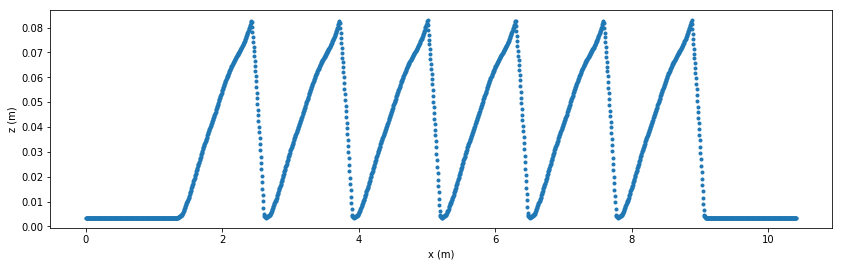

In [6]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 2000)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

# Model Runs for Paper

- Equilibrium vs non-Equlibrium
- Shallow water vs simple flow model
- modified Ycr (+20%, -20%)
- other models (Euler, Upwinding, MacCormick)

In [7]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.0012
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# Water Surface Elevation
sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 20 cm Case Non-Equilibrium

Note that I had to increase the resolution of the grid otherwise I was getting an odd error in the surface profile.

Surface at outlet:        0.24
Mean flow velocity:        0.41


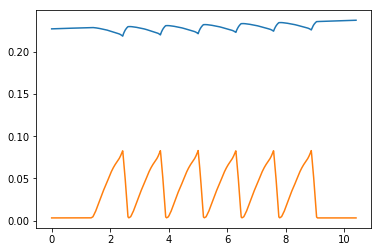

<Figure size 1008x432 with 0 Axes>

In [11]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print('Surface at outlet: ', "{:10.2f}".format(surf[len(x0)-1]), 'm')
print('Mean flow velocity: ', "{:10.2f}".format(model.get_uf().mean()), 'm/s')

In [ ]:

run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm','1.2mm')

#--------------------------------
#  Initialize the model
#--------------------------------

model = sdmodels.ShallowHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
#x0 = xc.copy()
zc = z0.copy()
nx = len(x0)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model( ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = exnermodels.EulerUpwindModel(nP)

model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)

h = model.get_hf()
surf = h + z0

verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name),verts)

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.005207603801900951
Grid nx = 2000
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.0012
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 5.215326699023401e-06
Time step: 5.0 mins - uavg: 0.41239356968334334 - Elevation 0.2289173429019754
Courant number: max 0.41783141388677014, mean0.06614796862799978


In [ ]:
fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0)
plt.plot(x0,zc)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 cm flow case

In [ ]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print('Surface at outlet: ', "{:10.2f}".format(surf[len(x0)-1]), 'm')
print('Mean flow velocity: ', "{:10.2f}".format(model.get_uf().mean()), 'm/s')

In [ ]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())